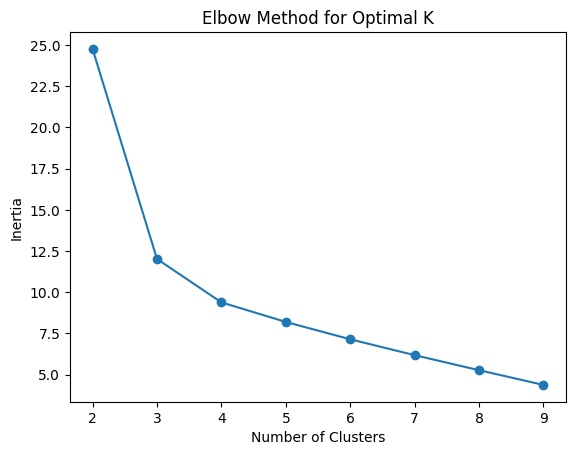

Silhouette Score: 0.9730
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 597, number of used features: 0
[LightGBM] [Info] Start training from score -0.085642
[LightGBM] [Info] Start training from score -2.703038
[LightGBM] [Info] Start training from score -4.782479
[LightGBM] [Info] Start training from score -5.698770
[LightGBM] [Info] Start training from score -5.698770
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
import lightgbm as lgb
import joblib
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('recipes.csv', encoding="utf-8", on_bad_lines="skip", quoting=3)

# Selecting relevant columns
columns = ['RecipeId', 'Name', 'CookTime', 'PrepTime', 'TotalTime', 'RecipeIngredientParts',
           'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
           'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeInstructions']
dataset = data[columns].dropna()

# Handle missing values
numeric_cols = ['Calories', 'FatContent', 'SugarContent', 'SodiumContent', 'ProteinContent','CarbohydrateContent']
# Convert columns to numeric, coercing errors to NaN
for col in numeric_cols:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

# Now apply median imputation
imputer = SimpleImputer(strategy='median')
for col in numeric_cols:
    dataset[col] = imputer.fit_transform(dataset[[col]]) # Applying to each col individually

# Outlier Handling
for col in numeric_cols:
    dataset[col] = winsorize(dataset[col], limits=[0.05, 0.05])

# Feature Engineering
dataset['Calories_per_protein'] = dataset['Calories'] / (dataset['ProteinContent'] + 1)
dataset['Fat_to_Carb_Ratio'] = dataset['FatContent'] / (dataset['CarbohydrateContent'] + 1)
dataset['Sodium_per_calorie'] = dataset['SodiumContent'] / (dataset['Calories'] + 1)

import re

def convert_duration(duration):
    """Convert ISO 8601 duration (PT1H30M) to minutes."""
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', duration)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        return hours * 60 + minutes
    return np.nan  # Return NaN for missing values

dataset['CookTime'] = dataset['CookTime'].apply(convert_duration)
dataset['PrepTime'] = dataset['PrepTime'].apply(convert_duration)

# Handle missing values after conversion
dataset['CookTime'] = dataset['CookTime'].fillna(dataset['CookTime'].median())
dataset['PrepTime'] = dataset['PrepTime'].fillna(dataset['PrepTime'].median())

# Compute TotalTime correctly
dataset['TotalTime'] = dataset['CookTime'] + dataset['PrepTime']

# Convert Ingredients and Instructions to TF-IDF Vector
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
ingredient_matrix = vectorizer.fit_transform(dataset['RecipeIngredientParts'].astype(str))
instruction_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
instruction_matrix = instruction_vectorizer.fit_transform(dataset['RecipeInstructions'].astype(str))

# Combine Feature Sets
combined_features = np.hstack((ingredient_matrix.toarray(), instruction_matrix.toarray()))

# Normalize numerical data
scaler = MinMaxScaler()
dataset[numeric_cols] = scaler.fit_transform(dataset[numeric_cols])

# Apply PCA for Dimensionality Reduction
pca = PCA(n_components=10)
pca_features = pca.fit_transform(combined_features)

# Determine optimal K for K-Means using Elbow Method
inertia_values = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_features)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Optimal Clusters
optimal_k = 5  # Adjust based on elbow method analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
dataset['Cluster'] = kmeans.fit_predict(pca_features)

# Evaluate clustering performance
silhouette_avg = silhouette_score(pca_features, dataset['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.4f}')

# Collaborative Filtering using KNN
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(pca_features)

def recommend_similar_recipes(recipe_index, num_recommendations=5):
    distances, indices = knn.kneighbors([pca_features[recipe_index]], n_neighbors=num_recommendations)
    return dataset.iloc[indices[0]]

# Train Classification Model (LightGBM with Hyperparameter Tuning)
X_train, X_test, y_train, y_test = train_test_split(dataset[numeric_cols], dataset['Cluster'], test_size=0.2, stratify=dataset['Cluster'], random_state=42)

lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=optimal_k, metric='multi_logloss')
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [-1, 3, 5, 7],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(lgb_model, param_grid, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Save Model and Data
joblib.dump(best_model, 'food_recommendation_model.pkl')
dataset.to_csv('processed_recipes.csv', index=False)